In [2]:
import os
import sys
import time
import itertools

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize

In [4]:
import autograd
import autograd.numpy as ag_np

from autograd.scipy.special import expit as ag_logistic_sigmoid

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

In [6]:
# Custom visualization routines
import visuals

# Wrappers around scipy.optimize solvers
import solvers

# Utility functions to compute true TP/FP/TN/FN and predict score for each example
from binary_clf_utils import calc_binary_clf_perf, calc_decision_score

In [7]:
# Load toydata generating module
import toydata

In [8]:
# Load modeling modules
import BCE
import SurrogateSigmoid
import SurrogateHinge
import SurrogateLog

In [9]:
# import Fathony and Kolter's adversarial prediction helper functions
import torch
from AdversarialPredictionUtils import LinearClassifier, RecallGvPrecision, TabularDataset
from ap_perf import PerformanceMetric, MetricLayer
from torch.utils.data import Dataset, DataLoader, random_split

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
figsize = (5, 5)

## Create Toy Data

In [12]:
x_ND, y_N, x_pos_ND, y_pos_N, x_neg_ND, y_neg_N = toydata.create_toy_dataset()

In [13]:
N = x_ND.shape[0]
Npos = x_pos_ND.shape[0]
Nneg = x_neg_ND.shape[0]

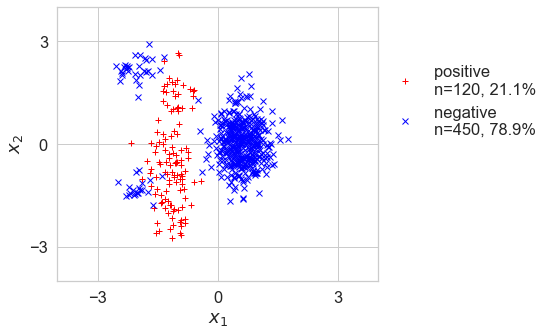

In [14]:
f, axs = plt.subplots(1, 1, figsize=(8,5))
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+', label='positive \nn=%2d, %.1f%%' % (Npos, 100*Npos/N))
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx', label='negative \nn=%2d, %.1f%%' % (Nneg, 100*Nneg/N))
axs.set_xlim([-4, 4]); axs.set_xticks([-3, 0, 3]);
axs.set_ylim([-4, 4]); axs.set_yticks([-3, 0, 3]);
axs.legend(
    loc='lower left',
    bbox_to_anchor= (1.01, 0.5),
    borderaxespad=0,
    frameon=False);
axs.set_xlabel(r'$x_1$')
axs.set_ylabel(r'$x_2$')

plt.tight_layout()
# f.savefig(os.path.join('images', 'toy_example.png'))

## Plan of Attack


We'd like to train a linear classifier on the toy dataset above.

We want this classifier to achieve some desired precision (set in the `alpha = ____` line below).

We wish to try 3 different objectives for solving this problem:

* BCE : Binary cross entropy
* SurrogateHinge : From Eban et al.
* SurrogateSigmoid : From this work

BCE is a convex problem, so we can just run it once and report how well it does.

The other two methods (Hinge, Sigmoid) are designed for a constrained optimization problem:

$$
    \text{argmin}_w f(w)
    \\
    \text{s.t.}~~ g(w) < 0
$$
where each one defines different lower/upper bounds used to define $f$ and $g$.

We transform the tough constrained problem into a standard unconstrained problem via the penalty method as:

$$
    \text{argmin}_w f(w) + \lambda \cdot \text{max}(g(w), 0)
$$

We'll try several logarithmically increasing values of $\lambda$.

At each $\lambda$, we'll try many initializations (20), drawing each entry of $w$ uniformly between -3 to +3.

Across all runs (all $\lambda$ and all initializations) we want to keep the best run.



We need to use a "common" loss across all tried $\lambda$ values so that solutions can be compared fairly. We'll grade each result's candidate solution $w'$ in terms of the following loss:

$$
    f(w') + 100000 \cdot  \text{max}(g(w'), 0)
$$

This way, any solution that does not satisfy the constraint is sure to have a huge value (here, minimization is good).

The function `calc_common_loss_from_ans_dict` defined below computes this "common" loss.

In [15]:
def calc_common_loss_from_ans_dict(ans_dict):
    k = ans_dict
    return (k['f']
        + 100000 * np.maximum(0.0, k['g']) 
        + (np.inf if k['recall']<0.01 else 0.0) # avoid degenerate solutions with no recall
       )

## Define problem to solve

In [20]:
alpha = 0.9      # precision to enforce. Used by both Sigmoid and Hinge methods

# Hyperparameters for our Sigmoid method                  
delta = 0.035     # small lift to zero-one loss to allow positive TP lower bounds
gamma = 7.0      # tolerance for the height of the sigmoid bounds (gamma * delta)
epsilon = 0.75    # tolerance for the width of the sigmoid bounds

In [21]:
sigm__lamb_candidate_values = np.logspace(-3, 3, 5)#(-3, 5, 20)
hin__lamb_candidate_values = np.logspace(-5, 5, 20)

In [22]:
random_state = 4233#8675309

## Try standard Binary Cross Entropy

In [23]:
bce_loss, bce_grad = BCE.make_loss_and_grad_for_dataset(x_ND, y_N)

In [24]:
best_w_D__bce, best_loss__bce, best_issat__bce, answers__bce = solvers.solve_minimimization_multiple_tries_with_lbfgs(
    x_ND, y_N, bce_loss, bce_grad, n_inits=5, alpha=alpha, random_state=random_state, verbose=False)

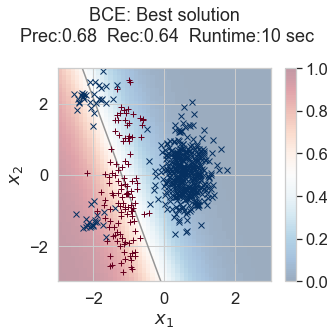

In [25]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_w_D__bce, x_ND, y_N,
    title_str='BCE: Best solution',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

plt.tight_layout()

#1-D threshold search
thr_offset_G = np.linspace(0.1, 10, 1000)
G = len(thr_offset_G)
precision_G = np.zeros(G)
recall_G = np.zeros(G)

for ii, thr_offset in enumerate(thr_offset_G):
    perfdict = visuals.calc_precision_recall(best_w_D__bce+np.array([0., 0., thr_offset_G[ii]]), x_ND, y_N)
    precision_G[ii] = perfdict['precision']
    recall_G[ii] = perfdict['recall']


# plt.savefig(os.path.join("images", "BCE_plus_threshold_search_solution.png"))

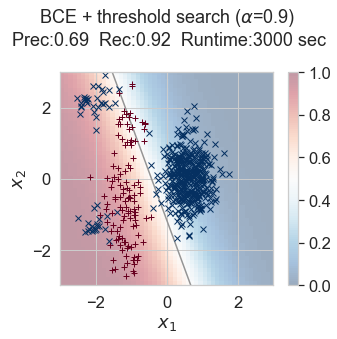

In [53]:
best_prec_ind = np.argmax(precision_G)
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_w_D__bce + np.array([0., 0., thr_offset_G[best_prec_ind]]), x_ND, y_N,
    title_str=r'BCE + threshold search ($\alpha$=0.9)',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

plt.tight_layout()
plt.savefig(os.path.join("images", "BCE_plus_threshold_search_solution_precision_90.png"))
plt.savefig(os.path.join("images", "BCE_plus_threshold_search_solution_precision_90.pdf"))

## Try sklearn logistic regression with class weight balanced (higher penalty to misclassification of positive examples)

/Users/preetishrath/Desktop/PhD/research/projects/loss_functions_for_precision_recall_balancing/toy_example_bounds_comparison/toy_example_precision_recall_multiple_bounds_comparison/visuals.py:82: UserWarning: No contour levels were found within the data range.
  vmin=-2, vmax=+2);
/Users/preetishrath/Desktop/PhD/research/projects/loss_functions_for_precision_recall_balancing/toy_example_bounds_comparison/toy_example_precision_recall_multiple_bounds_comparison/visuals.py:82: UserWarning: No contour levels were found within the data range.
  vmin=-2, vmax=+2);


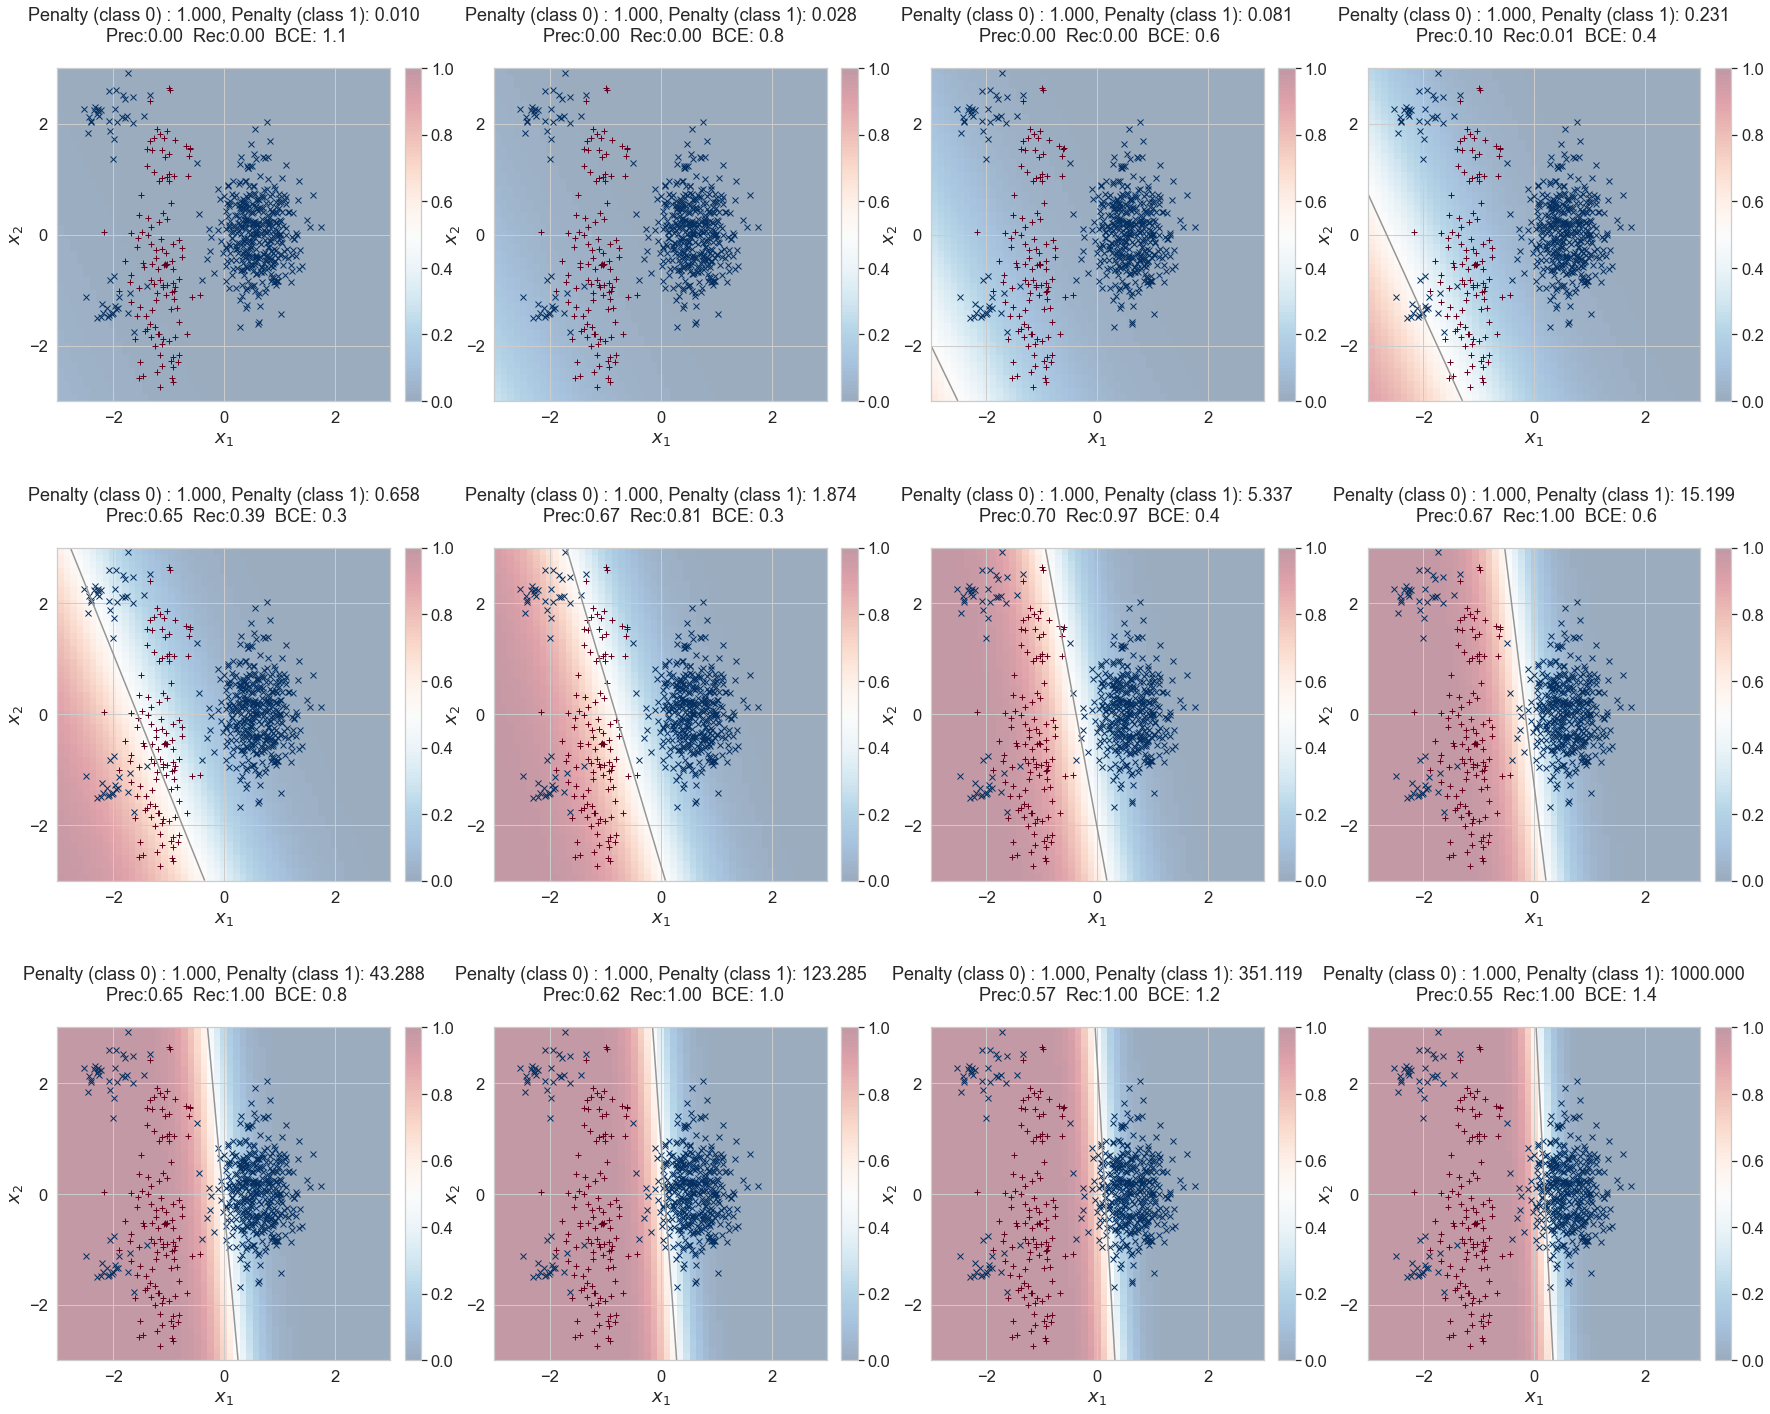

In [18]:
# factors = np.logspace(-1, 2.5, 12)
factors = np.logspace(-2, 3, 12)
# factors = np.linspace(0.1, 1.5, 12)
f, axs = plt.subplots(3, 4, figsize=(30,25))
axs_list = axs.flatten()

for ii, factor in enumerate(factors):
#     class_0_pen = (1/factor)*(N/Nneg)
#     class_1_pen = (factor)*(N/Npos)
    class_0_pen = 1
    class_1_pen = factor
    lr_clf = LogisticRegression(solver='lbfgs', max_iter=10000, tol=1e-6, class_weight={0 : class_0_pen, 1 : class_1_pen}).fit(x_ND, y_N)

    sklearn_lr_balanced_weights_ = np.hstack((lr_clf.coef_, lr_clf.intercept_[:,None]))[0]
    perf, im, cbar = visuals.pretty_plot_decision_boundary(
        sklearn_lr_balanced_weights_, x_ND, y_N,
        title_str='Penalty (class 0) : %.3f, Penalty (class 1): %.3f'%(class_0_pen, class_1_pen),
        x1_ticks=[-2, 0, 2],
        x2_ticks=[-2, 0, 2],
        G=51, H=51, ax=axs_list[ii]);

#     plt.tight_layout()
f.savefig(os.path.join('images', 'weighted_cross_entropy_solns.pdf'))

## Proposed sigmoid surrogate loss

In [20]:
n_inits = 300

best_w_D__sigm_by_lam = {}
best_loss__sigm_by_lam = {}
answers__sigm_by_lam = {}

for lamb in sigm__lamb_candidate_values:
    print("")
    print('Solving with the sigmoid bound with lambda = %.3g' % lamb)
    sigm_loss, sigm_grad, sigm_tp, sigm_fp = SurrogateSigmoid.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001,
        gamma=gamma, delta=delta, epsilon=epsilon, verbose=False, return_scale_corrected_loss=False)
    
    best_w_D__sigm_by_lam[lamb], best_loss__sigm_by_lam[lamb], _, answers__sigm_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, sigm_loss, sigm_grad,
            calc_FPUB=sigm_fp,
            calc_TPLB=sigm_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True,
            alpha=alpha, gamma=gamma, delta=delta, lamb=lamb, verbose=False)


Solving with the sigmoid bound with lambda = 0.001

Solving with the sigmoid bound with lambda = 0.0316

Solving with the sigmoid bound with lambda = 1

Solving with the sigmoid bound with lambda = 31.6

Solving with the sigmoid bound with lambda = 1e+03


In [21]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__sigm = sorted(itertools.chain(*answers__sigm_by_lam.values()),
                     key=calc_common_loss_from_ans_dict,
                     reverse=False)
best_result__sigm = ranked_answers__sigm[0]

best_result__sigm

{'w_D': array([ -0.99889913, -57.57442762, -90.24484538]),
 'loss': -0.06324559579232103,
 'is_sat': 1.0,
 'f': -36.08314585815734,
 'g': -0.00016842081636525563,
 'l2': 0.03315812515034483,
 'lamb': 1.0,
 'init_id': 40,
 'precision': 0.9062499999971679,
 'recall': 0.24166666666646527,
 'TP': 29,
 'TN': 447,
 'FP': 3,
 'FN': 91,
 'TP+gamma*delta': 58.400000000000006}

In [105]:
best_result__sigm['w_D']/max(abs(best_result__sigm['w_D']))

array([-0.02628487, -0.61414771, -1.        ])

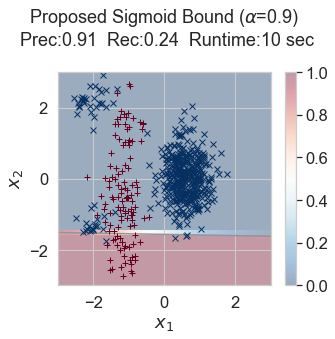

In [25]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_result__sigm['w_D'], x_ND, y_N,
#     title_str='Sigmoid : Best of %d' % len(ranked_answers__sigm),
    title_str=r'Proposed Sigmoid Bound ($\alpha$=0.9)',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

plt.tight_layout()
plt.savefig(os.path.join("images", "sigmoid_solution_precision_90.png"))
plt.savefig(os.path.join("images", "sigmoid_solution_precision_90.pdf"))

## Log loss as surrogate for 0-1 Loss

In [22]:
n_inits = 20
n_lam_values = 20

best_w_D__log_by_lam = {}
best_loss__log_by_lam = {}
answers__log_by_lam = {}

for lamb in hin__lamb_candidate_values:
    log_loss, log_grad, log_tp, log_fp = SurrogateLog.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001)
    
    best_w_D__log_by_lam[lamb], best_loss__log_by_lam[lamb], _, answers__log_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, log_loss, log_grad,
            calc_FPUB=log_fp,
            calc_TPLB=log_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True, alpha=alpha, lamb=lamb, verbose=False)

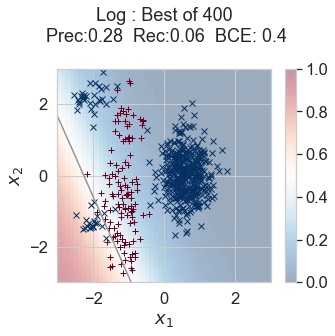

In [23]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__log = sorted(itertools.chain(*answers__log_by_lam.values()),
    key=calc_common_loss_from_ans_dict,
    reverse=False)

best_result__log = ranked_answers__log[0]

perf, im, cbar = visuals.pretty_plot_decision_boundary(best_result__log['w_D'], x_ND, y_N,
                                                       title_str='Log : Best of %d' % len(ranked_answers__log),
                                                       x1_ticks=[-2, 0, 2],
                                                       x2_ticks=[-2, 0, 2],
                                                       G=51, H=51, figsize=figsize);
plt.tight_layout()


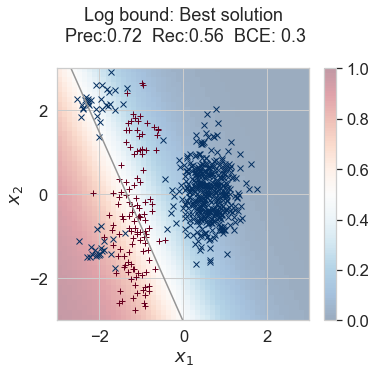

In [24]:
#1-D threshold search
thr_offset_G = np.linspace(0.1, 10, 1000)
G = len(thr_offset_G)
precision_G = np.zeros(G)
recall_G = np.zeros(G)

for ii, thr_offset in enumerate(thr_offset_G):
    perfdict = visuals.calc_precision_recall(best_result__log['w_D']+np.array([0., 0., thr_offset_G[ii]]), x_ND, y_N)
    precision_G[ii] = perfdict['precision']
    recall_G[ii] = perfdict['recall']

best_prec_ind = np.argmax(precision_G)
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_result__log['w_D'] + np.array([0., 0., thr_offset_G[best_prec_ind]]), x_ND, y_N,
    title_str='Log bound: Best solution',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);
plt.savefig(os.path.join("images", "log_bound_precision_90.pdf"))

## Eban et al's Hinge surrogate loss


In [29]:
n_inits = 20
n_lam_values = 20

best_w_D__hin_by_lam = {}
best_loss__hin_by_lam = {}
answers__hin_by_lam = {}

for lamb in hin__lamb_candidate_values:
    print("")
    print("Solving with Eban et al's Hinge bound with lambda = %.3g" % lamb)
#     print("-----------")
    hin_loss, hin_grad, hin_tp, hin_fp = SurrogateHinge.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001)
    
    best_w_D__hin_by_lam[lamb], best_loss__hin_by_lam[lamb], _, answers__hin_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, hin_loss, hin_grad,
            calc_FPUB=hin_fp,
            calc_TPLB=hin_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True, alpha=alpha, lamb=lamb, verbose=False)


Solving with Eban et al's Hinge bound with lambda = 1e-05

Solving with Eban et al's Hinge bound with lambda = 3.36e-05

Solving with Eban et al's Hinge bound with lambda = 0.000113

Solving with Eban et al's Hinge bound with lambda = 0.000379

Solving with Eban et al's Hinge bound with lambda = 0.00127

Solving with Eban et al's Hinge bound with lambda = 0.00428

Solving with Eban et al's Hinge bound with lambda = 0.0144

Solving with Eban et al's Hinge bound with lambda = 0.0483

Solving with Eban et al's Hinge bound with lambda = 0.162

Solving with Eban et al's Hinge bound with lambda = 0.546

Solving with Eban et al's Hinge bound with lambda = 1.83

Solving with Eban et al's Hinge bound with lambda = 6.16

Solving with Eban et al's Hinge bound with lambda = 20.7

Solving with Eban et al's Hinge bound with lambda = 69.5

Solving with Eban et al's Hinge bound with lambda = 234

Solving with Eban et al's Hinge bound with lambda = 785

Solving with Eban et al's Hinge bound with lambd

In [33]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__hin = sorted(itertools.chain(*answers__hin_by_lam.values()),
    key=calc_common_loss_from_ans_dict,
    reverse=False)

best_result__hin = ranked_answers__hin[0]
best_result__hin

{'w_D': array([-0.87605323, -0.60598615, -1.12008426]),
 'loss': 0.14347579277606665,
 'is_sat': 0.0,
 'f': -12.644486709949966,
 'g': 581.518844102919,
 'l2': 1.1346884750943257e-05,
 'lamb': 0.1623776739188721,
 'init_id': 10,
 'precision': 0.7938144329888723,
 'recall': 0.6416666666661319,
 'TP': 77,
 'TN': 430,
 'FP': 20,
 'FN': 43}

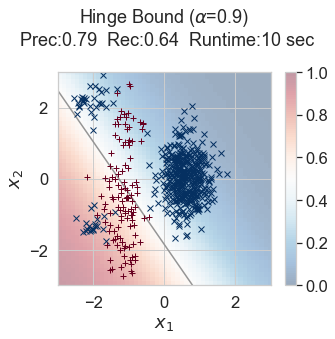

In [31]:
# perf, im, cbar = visuals.pretty_plot_decision_boundary(best_result__hin['w_D'], x_ND, y_N,
#                                                        title_str='Hinge : Best of %d' % len(ranked_answers__hin),
#                                                        x1_ticks=[-2, 0, 2],
#                                                        x2_ticks=[-2, 0, 2],
#                                                        G=51, H=51, figsize=figsize);

perf, im, cbar = visuals.pretty_plot_decision_boundary(best_result__hin['w_D'], x_ND, y_N,
                                                       title_str=r'Hinge Bound ($\alpha$=0.9)',
                                                       x1_ticks=[-2, 0, 2],
                                                       x2_ticks=[-2, 0, 2],
                                                       G=51, H=51, figsize=figsize);
plt.tight_layout()
plt.savefig(os.path.join("images", "hinge_solution_precision_90.png"))
plt.savefig(os.path.join("images", "hinge_solution_precision_90.pdf"))

## Fathony et al's adversarial prediction

In [23]:
recall_gv_precision_90 = RecallGvPrecision(0.9)
recall_gv_precision_90.initialize()
recall_gv_precision_90.enforce_special_case_positive()
recall_gv_precision_90.set_cs_special_case_positive(True)

# performance metric
pm = recall_gv_precision_90

trainset = TabularDataset(x_ND, y_N)


batch_size = len(x_ND) # full batch
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

method = "ap-perf"              # uncomment if we want to use ap-perf objective 
# method = "bce-loss"           # uncomment if we want to use bce-loss objective

torch.manual_seed(46364)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

nvar = x_ND.shape[1]
model = LinearClassifier(nvar).to(device)

if method == "ap-perf":
    criterion = MetricLayer(pm).to(device)
    lr = 0.0006
    weight_decay = 0
else:
    criterion = nn.BCEWithLogitsLoss().to(device)
    lr = 1e-2
    weight_decay = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

verbose=True

for epoch in range(11): # epoch 11 was the best checkpoint after running 50 epochs

    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
    # evaluate after each epoch
    model.eval()

    # train
    train_data = torch.tensor(x_ND).to(device)
    tr_output = model(train_data)
    tr_pred = (tr_output >= 0.0).float()
    tr_pred_np = tr_pred.cpu().numpy()
    
    train_acc = np.sum(y_N == tr_pred_np) / len(y_N)
    train_metric = pm.compute_metric(tr_pred_np, y_N)
    train_constraint = pm.compute_constraints(tr_pred_np, y_N)
    
    
    model.train()
    
    if verbose:
        print('#{} loss : {:.2f} | Acc tr: {:.5f} | Metric tr: {:.5f} | Constraint tr: {:.5f}'.format(
            epoch, loss.detach().numpy()[0], train_acc, train_metric, train_constraint[0]))
    
opt_w_D_adversarial_90 = np.zeros(3)
opt_w_D_adversarial_90[:2] = list(model.parameters())[0].data[0]
opt_w_D_adversarial_90[2] = list(model.parameters())[1].data[0]

#0 loss : 37.97 | Acc tr: 0.84912 | Metric tr: 0.98333 | Constraint tr: 0.58416
#1 loss : 25.59 | Acc tr: 0.85789 | Metric tr: 0.90833 | Constraint tr: 0.60894
#2 loss : 16.59 | Acc tr: 0.86667 | Metric tr: 0.79167 | Constraint tr: 0.65068
#3 loss : 11.42 | Acc tr: 0.88070 | Metric tr: 0.75833 | Constraint tr: 0.70000
#4 loss : 8.73 | Acc tr: 0.88772 | Metric tr: 0.75833 | Constraint tr: 0.72222
#5 loss : 6.36 | Acc tr: 0.87544 | Metric tr: 0.70000 | Constraint tr: 0.70588
#6 loss : 4.39 | Acc tr: 0.82632 | Metric tr: 0.47500 | Constraint tr: 0.61290
#7 loss : 2.99 | Acc tr: 0.80877 | Metric tr: 0.46667 | Constraint tr: 0.55446
#8 loss : 2.38 | Acc tr: 0.83333 | Metric tr: 0.39167 | Constraint tr: 0.68116
#9 loss : 2.01 | Acc tr: 0.88596 | Metric tr: 0.87500 | Constraint tr: 0.67742
#10 loss : 2.96 | Acc tr: 0.81228 | Metric tr: 0.10833 | Constraint tr: 1.00000


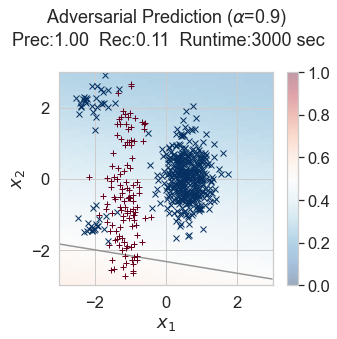

In [52]:
# uncomment line below to set the optimal bound by AP without training because if takes nearly 1 hour
opt_w_D_adversarial_90 = ag_np.asarray([-0.046, -0.280, -0.653]) 
perf, im, cbar = visuals.pretty_plot_decision_boundary(opt_w_D_adversarial_90, x_ND, y_N,
                                                       title_str=r'Adversarial Prediction ($\alpha$=0.9)',
                                                       x1_ticks=[-2, 0, 2],
                                                       x2_ticks=[-2, 0, 2],
                                                       G=51, H=51, figsize=figsize);

plt.tight_layout()
# plt.savefig(os.path.join("images", "adversarial_prediction_precision_90.png"))
plt.savefig(os.path.join("images", "adversarial_prediction_precision_90.pdf"))

In [50]:
im.axes.get_aspect()

1.0

## Would the hinge loss prefer the solution from sigmoid loss?

No. The best result from the Sigmoid objective has way worse score under the Hinge's loss.

In [112]:
def calc_common_hinge_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = hin_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [113]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm)

139434208.0066319

In [114]:
calc_common_hinge_loss_from_ans_dict(best_result__hin)

58151871.76580519

In [115]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm) < calc_common_hinge_loss_from_ans_dict(best_result__hin)

False

## Would the sigmoid loss prefer the solution from hinge?

No. The best result from the Hinge objective has way worse score under the Sigmoid's loss.

In [116]:
def calc_common_sigmoid_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = sigm_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [117]:
calc_common_sigmoid_loss_from_ans_dict(best_result__sigm)

-33.692070310768756

In [118]:
calc_common_sigmoid_loss_from_ans_dict(best_result__hin)

23938624.92597561

In [119]:
calc_common_sigmoid_loss_from_ans_dict(best_result__hin) < calc_common_sigmoid_loss_from_ans_dict(best_result__sigm)

False

## Does the sigmoid loss or hinge loss prefer the optimal solution (obtained via grid search)?

The sigmoid loss clearly prefers the optimal solution.

In [122]:
best_result_grid_search = {'w_D' : np.array([-0.083, -3.16, -5.]), 'recall': 0.242}

In [123]:
calc_common_sigmoid_loss_from_ans_dict(best_result_grid_search)

5593487.863493889

In [126]:
calc_common_hinge_loss_from_ans_dict(best_result_grid_search)

56375563.59263382

In [130]:
is_sigmoid_loss_lower = calc_common_sigmoid_loss_from_ans_dict(best_result_grid_search) < calc_common_hinge_loss_from_ans_dict(best_result_grid_search)
print ('Is loss from sigmoid bound better than hinge at the optimal solution : ' + str(is_sigmoid_loss_lower))

Is loss from sigmoid bound better than hinge at the optimal solution : True
